In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class FraudDetectionPipeline:
    def __init__(self, data_path):
        """Initialize the fraud detection pipeline with data path."""
        self.data_path = data_path
        self.df = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.results = {}

    def load_data(self):
        """Load the dataset from CSV file."""
        try:
            self.df = pd.read_csv(self.data_path)
            print("Data loaded successfully!")
            print(f"Dataset shape: {self.df.shape}")
            return self.df
        except FileNotFoundError:
            print(f"Error: Dataset not found at {self.data_path}")
            self.df = None # Ensure self.df is explicitly set to None on failure
            return None
        except Exception as e:
            print(f"Error loading data: {e}")
            self.df = None # Ensure self.df is explicitly set to None on failure
            return None

    def explore_data(self):
        """Perform exploratory data analysis."""
        if self.df is None:
            print("Data not loaded. Cannot perform exploration.")
            return
        print("\n=== DATASET OVERVIEW ===")
        print(f"Dataset shape: {self.df.shape}")
        print(f"\nColumns: {list(self.df.columns)}")

        print("\n=== DATA TYPES ===")
        print(self.df.dtypes)

        print("\n=== MISSING VALUES ===")
        missing_values = self.df.isnull().sum()
        print(missing_values[missing_values > 0])

        print("\n=== BASIC STATISTICS ===")
        print(self.df.describe())

        print("\n=== FRAUD DISTRIBUTION ===")
        fraud_counts = self.df['IsFraud'].value_counts()
        print(fraud_counts)
        print(f"Fraud percentage: {fraud_counts[1] / len(self.df) * 100:.2f}%")

    def visualize_data(self):
        """Create visualizations for the dataset."""
        # Added check to prevent error if data wasn't loaded
        if self.df is None:
            print("Data not loaded. Cannot perform visualization.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Fraud distribution
        self.df['IsFraud'].value_counts().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Fraud Distribution')
        axes[0,0].set_xlabel('Is Fraud (0: No, 1: Yes)')
        axes[0,0].set_ylabel('Count')

        # Amount distribution
        axes[0,1].hist(self.df['Amount'], bins=50, edgecolor='black', alpha=0.7)
        axes[0,1].set_title('Transaction Amount Distribution')
        axes[0,1].set_xlabel('Amount')
        axes[0,1].set_ylabel('Frequency')

        # Amount by fraud status
        sns.boxplot(data=self.df, x='IsFraud', y='Amount', ax=axes[1,0])
        axes[1,0].set_title('Transaction Amount by Fraud Status')

        # Category distribution
        category_counts = self.df['Category'].value_counts()
        axes[1,1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
        axes[1,1].set_title('Transaction Categories')

        plt.tight_layout()
        plt.show()

        # Fraud by category
        plt.figure(figsize=(12, 6))
        fraud_by_category = self.df.groupby(['Category', 'IsFraud']).size().unstack(fill_value=0)
        fraud_by_category.plot(kind='bar')
        plt.title('Fraud Cases by Category')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.legend(['Not Fraud', 'Fraud'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Fraud by location
        plt.figure(figsize=(15, 8))
        fraud_by_location = self.df[self.df['IsFraud'] == 1]['Location'].value_counts().head(10)
        fraud_by_location.plot(kind='bar')
        plt.title('Top 10 Locations with Most Fraud Cases')
        plt.xlabel('Location')
        plt.ylabel('Fraud Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocess the data for machine learning."""
        if self.df is None:
             print("Data not loaded. Cannot perform preprocessing.")
             return None, None # Return None for X and y

        # Create a copy of the dataframe
        df_processed = self.df.copy()

        # Convert TransactionTime to datetime
        df_processed['TransactionTime'] = pd.to_datetime(df_processed['TransactionTime'])

        # Extract time features
        df_processed['Hour'] = df_processed['TransactionTime'].dt.hour
        df_processed['DayOfWeek'] = df_processed['TransactionTime'].dt.dayofweek
        df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

        # Extract IP address network parts
        df_processed['IP_Network'] = df_processed['IPAddress'].str.split('.').str[0:2].str.join('.')

        # Handle categorical variables
        # Location features
        # Added check for potential None values in split result
        df_processed['City'] = df_processed['Location'].str.split(',').str[0].str.strip()
        df_processed['State'] = df_processed['Location'].str.split(',').str[1].str.strip()


        # Amount-based features
        df_processed['Amount_Log'] = np.log1p(df_processed['Amount'])
        df_processed['Amount_Squared'] = df_processed['Amount'] ** 2

        # User behavior features
        user_stats = df_processed.groupby('UserID').agg({
            'Amount': ['mean', 'std', 'sum'],
            'TransactionID': 'count'
        }).reset_index()
        user_stats.columns = ['UserID', 'User_Avg_Amount', 'User_Std_Amount', 'User_Total_Amount', 'User_Transaction_Count']

        # Merge user statistics
        df_processed = df_processed.merge(user_stats, on='UserID', how='left')

        # Fill missing values for user statistics
        df_processed['User_Std_Amount'] = df_processed['User_Std_Amount'].fillna(0)

        # One-hot encode categorical variables
        categorical_features = ['Merchant', 'Category', 'Device', 'City', 'State', 'IP_Network']
        df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

        # Select features for modeling
        feature_columns = [col for col in df_encoded.columns if col not in ['TransactionID', 'UserID', 'TransactionTime', 'Location', 'IPAddress', 'IsFraud']]

        self.X = df_encoded[feature_columns]
        self.y = df_encoded['IsFraud']

        # Handle any remaining missing values
        imputer = SimpleImputer(strategy='median')
        self.X = pd.DataFrame(imputer.fit_transform(self.X), columns=self.X.columns)

        print(f"Feature matrix shape: {self.X.shape}")
        print(f"Number of features: {len(feature_columns)}")

        return self.X, self.y

    def split_data(self, test_size=0.2, random_state=42):
        """Split the data into training and testing sets."""
        # Added check to prevent error if X or y are None
        if self.X is None or self.y is None:
            print("Data not preprocessed. Cannot split data.")
            return None, None, None, None

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )

        print(f"Training set shape: {self.X_train.shape}")
        print(f"Testing set shape: {self.X_test.shape}")

        # Scale the features
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        return self.X_train, self.X_test, self.y_train, self.y_test

    def balance_data(self):
        """Apply SMOTE to balance the dataset."""
        # Added check to prevent error if training data is None
        if self.X_train_scaled is None or self.y_train is None:
            print("Training data not split or scaled. Cannot balance data.")
            return None, None

        smote = SMOTE(random_state=42)
        self.X_train_balanced, self.y_train_balanced = smote.fit_resample(self.X_train_scaled, self.y_train)

        print(f"Original training set fraud distribution:")
        print(self.y_train.value_counts())
        print(f"\nBalanced training set fraud distribution:")
        print(pd.Series(self.y_train_balanced).value_counts())

        return self.X_train_balanced, self.y_train_balanced

    def train_models(self):
        """Train multiple machine learning models."""
        # Added check to prevent error if scaled data is None
        if self.X_train_scaled is None or self.y_train is None or self.X_test_scaled is None or self.y_test is None:
             print("Data not split or scaled. Cannot train models.")
             return

        # Define models
        self.models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
            'SVM': SVC(random_state=42, probability=True)
        }

        # Train models
        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Use balanced data for training if available, otherwise use scaled training data
            X_train_fit = self.X_train_balanced if hasattr(self, 'X_train_balanced') and self.X_train_balanced is not None else self.X_train_scaled
            y_train_fit = self.y_train_balanced if hasattr(self, 'y_train_balanced') and self.y_train_balanced is not None else self.y_train

            if X_train_fit is None or y_train_fit is None:
                 print(f"Skipping training for {name} due to missing training data.")
                 continue

            model.fit(X_train_fit, y_train_fit)

            # Make predictions
            y_pred = model.predict(self.X_test_scaled)
            y_pred_proba = model.predict_proba(self.X_test_scaled)[:, 1]

            # Store results
            self.results[name] = {
                'model': model,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'accuracy': model.score(self.X_test_scaled, self.y_test),
                'auc_score': roc_auc_score(self.y_test, y_pred_proba)
            }

            print(f"{name} Accuracy: {self.results[name]['accuracy']:.4f}")
            print(f"{name} AUC Score: {self.results[name]['auc_score']:.4f}")

    def evaluate_models(self):
        """Evaluate all trained models."""
        if not self.results or self.y_test is None or self.X_test_scaled is None:
            print("No models trained or test data is missing. Cannot evaluate models.")
            return

        plt.figure(figsize=(15, 10))

        # Plot ROC curves
        plt.subplot(2, 2, 1)
        for name, result in self.results.items():
            # Check if probabilities are available for ROC curve
            if 'probabilities' in result:
                fpr, tpr, _ = roc_curve(self.y_test, result['probabilities'])
                plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc_score']:.3f})")
            else:
                 print(f"Probabilities not available for {name}, skipping ROC curve.")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()

        # Plot Precision-Recall curves
        plt.subplot(2, 2, 2)
        for name, result in self.results.items():
             # Check if probabilities are available for Precision-Recall curve
            if 'probabilities' in result:
                precision, recall, _ = precision_recall_curve(self.y_test, result['probabilities'])
                plt.plot(recall, precision, label=f"{name}")
            else:
                 print(f"Probabilities not available for {name}, skipping Precision-Recall curve.")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend()

        # Compare accuracies
        plt.subplot(2, 2, 3)
        # Filter out models that might not have results if training was skipped
        valid_results = {name: result for name, result in self.results.items() if 'accuracy' in result}
        if valid_results:
            accuracies = [result['accuracy'] for result in valid_results.values()]
            model_names = list(valid_results.keys())
            bars = plt.bar(model_names, accuracies)
            plt.ylabel('Accuracy')
            plt.title('Model Accuracies')
            plt.xticks(rotation=45)

            # Add value labels on bars
            for bar, acc in zip(bars, accuracies):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
                        f'{acc:.3f}', ha='center', va='bottom')
        else:
            plt.text(0.5, 0.5, 'No models evaluated', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
            plt.title('Model Accuracies')


        # Compare AUC scores
        plt.subplot(2, 2, 4)
        # Filter out models that might not have results if training was skipped
        valid_results = {name: result for name, result in self.results.items() if 'auc_score' in result}
        if valid_results:
            auc_scores = [result['auc_score'] for result in valid_results.values()]
            model_names = list(valid_results.keys())
            bars = plt.bar(model_names, auc_scores)
            plt.ylabel('AUC Score')
            plt.title('Model AUC Scores')
            plt.xticks(rotation=45)

            # Add value labels on bars
            for bar, auc in zip(bars, auc_scores):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
                        f'{auc:.3f}', ha='center', va='bottom')
        else:
             plt.text(0.5, 0.5, 'No models evaluated', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
             plt.title('Model AUC Scores')


        plt.tight_layout()
        plt.show()

        # Print detailed classification reports
        print("\n=== DETAILED MODEL EVALUATION ===")
        for name, result in self.results.items():
             if 'predictions' in result:
                print(f"\n{name} Classification Report:")
                print(classification_report(self.y_test, result['predictions']))

                print(f"\n{name} Confusion Matrix:")
                cm = confusion_matrix(self.y_test, result['predictions'])
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f'{name} Confusion Matrix')
                plt.ylabel('Actual')
                plt.xlabel('Predicted')
                plt.show()
             else:
                 print(f"Skipping detailed report for {name} due to missing predictions.")


    def hyperparameter_tuning(self, model_name='Random Forest'):
        """Perform hyperparameter tuning for the best model."""
        # Added check to prevent error if scaled data is None
        if self.X_train_scaled is None or self.y_train is None or self.X_test_scaled is None or self.y_test is None:
            print("Data not split or scaled. Cannot perform hyperparameter tuning.")
            return None

        print(f"\nPerforming hyperparameter tuning for {model_name}...")

        if model_name == 'Random Forest':
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            model = RandomForestClassifier(random_state=42)
        elif model_name == 'Gradient Boosting':
            param_grid = {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'min_samples_split': [2, 5, 10]
            }
            model = GradientBoostingClassifier(random_state=42)
        else:
            print(f"Hyperparameter tuning not implemented for {model_name}")
            return None

        # Perform grid search
        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
        )

        # Use balanced data for tuning if available, otherwise use scaled training data
        X_train_tune = self.X_train_balanced if hasattr(self, 'X_train_balanced') and self.X_train_balanced is not None else self.X_train_scaled
        y_train_tune = self.y_train_balanced if hasattr(self, 'y_train_balanced') and self.y_train_balanced is not None else self.y_train

        if X_train_tune is None or y_train_tune is None:
             print("Training data not available for tuning.")
             return None

        grid_search.fit(X_train_tune, y_train_tune)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        # Evaluate best model
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(self.X_test_scaled)
        y_pred_proba = best_model.predict_proba(self.X_test_scaled)[:, 1]

        print(f"Test accuracy: {best_model.score(self.X_test_scaled, self.y_test):.4f}")
        print(f"Test AUC score: {roc_auc_score(self.y_test, y_pred_proba):.4f}")

        return grid_search.best_estimator_

    def feature_importance(self, model_name='Random Forest'):
        """Analyze feature importance."""
        if model_name not in self.results or self.X is None:
            print(f"{model_name} not found in results or features are missing. Please train the model and ensure preprocessing was successful first.")
            return

        model = self.results[model_name]['model']

        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            feature_names = self.X.columns

            # Create DataFrame for feature importance
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)

            # Plot top 20 features
            plt.figure(figsize=(10, 8))
            top_features = feature_importance_df.head(20)
            sns.barplot(data=top_features, x='importance', y='feature')
            plt.title(f'Top 20 Feature Importance - {model_name}')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()

            print(f"\nTop 10 Most Important Features for {model_name}:")
            print(feature_importance_df.head(10))

            return feature_importance_df
        else:
            print(f"{model_name} does not have feature_importances_ attribute")
            return None

    def predict_new_data(self, new_data, model_name='Random Forest'):
        """Make predictions on new data."""
        if model_name not in self.results or self.scaler is None:
            print(f"{model_name} not found in results or scaler is missing. Please train the model and scale the data first.")
            return None

        model = self.results[model_name]['model']

        # Preprocess new data (you'll need to implement the same preprocessing)
        # This is a simplified version - in practice, you'd need the full preprocessing pipeline
        # Note: This part is incomplete and assumes new_data has the same columns as self.X before scaling
        # A proper implementation would involve replicating the preprocessing steps from preprocess_data
        try:
            new_data_scaled = self.scaler.transform(new_data)
        except Exception as e:
            print(f"Error scaling new data: {e}")
            print("Please ensure new_data has the same columns as the training data used for scaling.")
            return None

        # Make predictions
        predictions = model.predict(new_data_scaled)
        probabilities = model.predict_proba(new_data_scaled)[:, 1]

        results_df = pd.DataFrame({
            'Is_Fraud': predictions,
            'Fraud_Probability': probabilities
        })

        return results_df

    def run_complete_pipeline(self):
        """Run the complete fraud detection pipeline."""
        print("=== STARTING FRAUD DETECTION PIPELINE ===")

        # Load data
        print("\n1. Loading data...")
        if self.load_data() is None:
            print("Data loading failed. Aborting pipeline.")
            return None # Stop if data loading fails

        # Explore data
        print("\n2. Exploring data...")
        self.explore_data()

        # Visualize data
        print("\n3. Visualizing data...")
        self.visualize_data() # visualize_data now has a check for self.df

        # Preprocess data
        print("\n4. Preprocessing data...")
        X, y = self.preprocess_data()
        if X is None or y is None:
            print("Data preprocessing failed. Aborting pipeline.")
            return None

        # Split data
        print("\n5. Splitting data...")
        X_train, X_test, y_train, y_test = self.split_data()
        if X_train is None: # Check if split was successful
             print("Data splitting failed. Aborting pipeline.")
             return None


        # Balance data
        print("\n6. Balancing data...")
        X_train_balanced, y_train_balanced = self.balance_data()
        # Balancing might fail or not be necessary, pipeline can continue

        # Train models
        print("\n7. Training models...")
        self.train_models()
        if not self.results: # Check if any models were trained
             print("Model training failed. Aborting evaluation and subsequent steps.")
             return None


        # Evaluate models
        print("\n8. Evaluating models...")
        self.evaluate_models()

        # Feature importance
        print("\n9. Analyzing feature importance...")
        self.feature_importance()

        # Hyperparameter tuning
        print("\n10. Hyperparameter tuning...")
        # Decide which model to tune, e.g., based on AUC score from results
        best_model_name = max(self.results, key=lambda name: self.results[name]['auc_score']) if self.results else 'Random Forest'
        best_model = self.hyperparameter_tuning(model_name=best_model_name)


        print("\n=== PIPELINE COMPLETED ===")
        return best_model

# Example usage
if __name__ == "__main__":
    # Initialize the pipeline
    # Make sure 'dataset.csv' exists in the same directory or provide the correct path
    fraud_detector = FraudDetectionPipeline('dataset.csv')

    # Run the complete pipeline
    best_model = fraud_detector.run_complete_pipeline()

    # You can also run individual steps:
    # fraud_detector.load_data()
    # fraud_detector.explore_data()
    # fraud_detector.visualize_data()
    # fraud_detector.preprocess_data()
    # fraud_detector.split_data()
    # fraud_detector.balance_data()
    # fraud_detector.train_models()
    # fraud_detector.evaluate_models()
    # fraud_detector.feature_importance()
    # fraud_detector.hyperparameter_tuning()


=== STARTING FRAUD DETECTION PIPELINE ===

1. Loading data...
Error: Dataset not found at dataset.csv
Data loading failed. Aborting pipeline.


FRAUD DETECTION DATASET - EXPLORATORY DATA ANALYSIS

1. BASIC DATASET INFORMATION
------------------------------
Dataset shape: (53, 10)
Number of rows: 53
Number of columns: 10

2. DATA TYPES AND BASIC INFO
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    53 non-null     int64  
 1   UserID           53 non-null     int64  
 2   Amount           53 non-null     float64
 3   TransactionTime  53 non-null     object 
 4   Merchant         53 non-null     object 
 5   Category         53 non-null     object 
 6   Location         53 non-null     object 
 7   Device           52 non-null     object 
 8   IPAddress        52 non-null     object 
 9   IsFraud          52 non-null     float64
dtypes: float64(2), int64(2), object(6)
memory usage: 4.3+ KB
None

3. FIRST FEW ROWS
--------------------

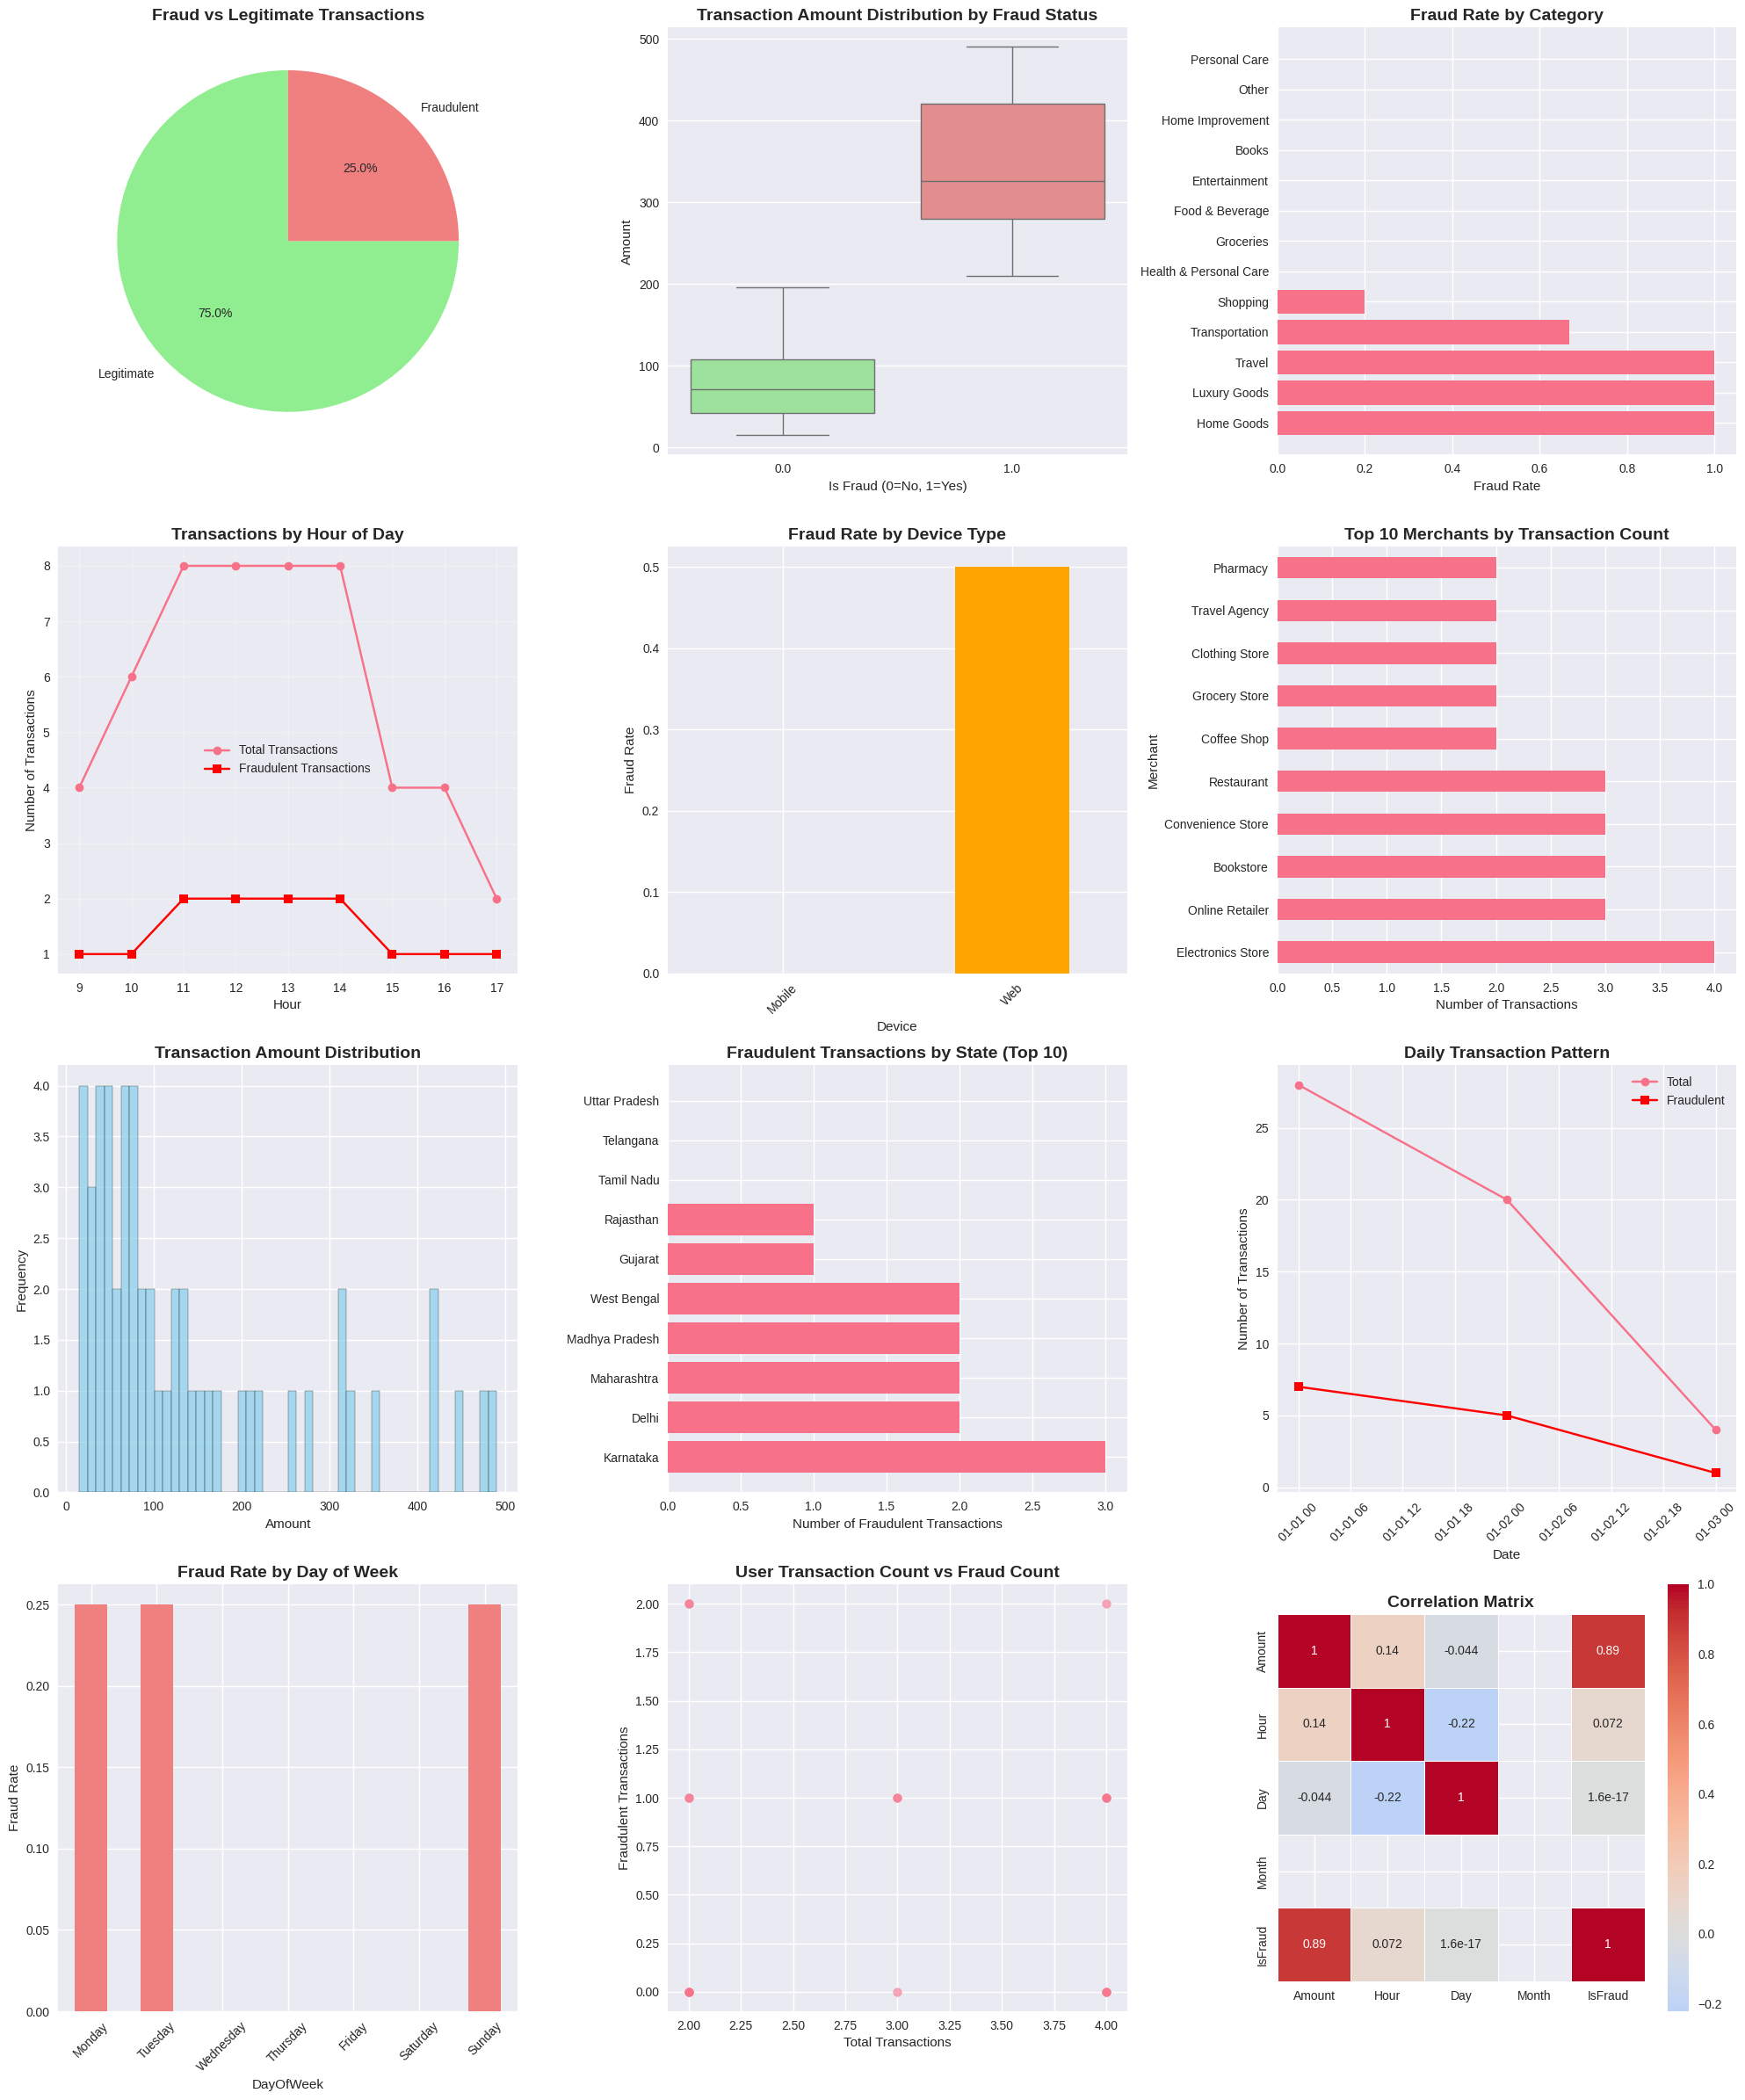


9. DETAILED STATISTICAL ANALYSIS
------------------------------

9.1 FRAUD STATISTICS BY CATEGORY
                        Total_Transactions  Fraudulent_Transactions  \
Category                                                              
Home Goods                               1                      1.0   
Luxury Goods                             5                      5.0   
Travel                                   2                      2.0   
Transportation                           3                      2.0   
Shopping                                15                      3.0   
Health & Personal Care                   4                      0.0   
Groceries                                2                      0.0   
Food & Beverage                          7                      0.0   
Entertainment                            1                      0.0   
Books                                    2                      0.0   
Home Improvement                         2       

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# 1. DATA LOADING AND BASIC INFORMATION
print("=" * 50)
print("FRAUD DETECTION DATASET - EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Load the dataset
df = pd.read_csv('dataset.csv.csv')

print("\n1. BASIC DATASET INFORMATION")
print("-" * 30)
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Display basic info
print("\n2. DATA TYPES AND BASIC INFO")
print("-" * 30)
print(df.info())

print("\n3. FIRST FEW ROWS")
print("-" * 30)
print(df.head())

print("\n4. BASIC STATISTICS")
print("-" * 30)
print(df.describe())

# 5. MISSING VALUES ANALYSIS
print("\n5. MISSING VALUES")
print("-" * 30)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing Percentage': missing_percentage.values
}).sort_values('Missing Count', ascending=False)
print(missing_df)

# 6. DATA PREPROCESSING
print("\n6. DATA PREPROCESSING")
print("-" * 30)

# Convert TransactionTime to datetime
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

# Extract date and time features
df['Date'] = df['TransactionTime'].dt.date
df['Hour'] = df['TransactionTime'].dt.hour
df['Day'] = df['TransactionTime'].dt.day
df['Month'] = df['TransactionTime'].dt.month
df['Year'] = df['TransactionTime'].dt.year
df['DayOfWeek'] = df['TransactionTime'].dt.day_name()

print("Added time-based features")

# 7. FRAUD ANALYSIS
print("\n7. FRAUD ANALYSIS")
print("-" * 30)

# Overall fraud rate
fraud_rate = df['IsFraud'].mean()
print(f"Overall fraud rate: {fraud_rate:.2%}")

# Fraud counts
fraud_counts = df['IsFraud'].value_counts()
print(f"\nFraud distribution:")
print(fraud_counts)

# 8. VISUALIZATIONS
print("\n8. CREATING VISUALIZATIONS")
print("-" * 30)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 24))

# 8.1 Fraud Distribution Pie Chart
plt.subplot(4, 3, 1)
plt.pie(fraud_counts.values, labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('Fraud vs Legitimate Transactions', fontsize=14, fontweight='bold')

# 8.2 Amount Distribution by Fraud Status
plt.subplot(4, 3, 2)
sns.boxplot(data=df, x='IsFraud', y='Amount', palette=['lightgreen', 'lightcoral'])
plt.title('Transaction Amount Distribution by Fraud Status', fontsize=14, fontweight='bold')
plt.xlabel('Is Fraud (0=No, 1=Yes)')
plt.ylabel('Amount')

# 8.3 Fraud by Category
plt.subplot(4, 3, 3)
fraud_by_category = df.groupby('Category')['IsFraud'].agg(['count', 'sum', 'mean']).sort_values('mean', ascending=False)
plt.barh(fraud_by_category.index, fraud_by_category['mean'])
plt.title('Fraud Rate by Category', fontsize=14, fontweight='bold')
plt.xlabel('Fraud Rate')

# 8.4 Transactions by Hour
plt.subplot(4, 3, 4)
hourly_fraud = df.groupby('Hour')['IsFraud'].agg(['count', 'sum']).reset_index()
plt.plot(hourly_fraud['Hour'], hourly_fraud['count'], marker='o', label='Total Transactions')
plt.plot(hourly_fraud['Hour'], hourly_fraud['sum'], marker='s', label='Fraudulent Transactions', color='red')
plt.title('Transactions by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True, alpha=0.3)

# 8.5 Fraud by Device Type
plt.subplot(4, 3, 5)
device_fraud = df.groupby('Device')['IsFraud'].mean()
device_fraud.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Fraud Rate by Device Type', fontsize=14, fontweight='bold')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)

# 8.6 Top 10 Merchants by Transaction Count
plt.subplot(4, 3, 6)
top_merchants = df['Merchant'].value_counts().head(10)
top_merchants.plot(kind='barh')
plt.title('Top 10 Merchants by Transaction Count', fontsize=14, fontweight='bold')
plt.xlabel('Number of Transactions')

# 8.7 Amount Distribution
plt.subplot(4, 3, 7)
plt.hist(df['Amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Transaction Amount Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# 8.8 Fraud by State/Location
plt.subplot(4, 3, 8)
df['State'] = df['Location'].str.split(',').str[1].str.strip()
state_fraud = df.groupby('State')['IsFraud'].agg(['count', 'sum', 'mean']).sort_values('sum', ascending=False)
top_states = state_fraud.head(10)
plt.barh(top_states.index, top_states['sum'])
plt.title('Fraudulent Transactions by State (Top 10)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Fraudulent Transactions')

# 8.9 Daily Transaction Pattern
plt.subplot(4, 3, 9)
daily_pattern = df.groupby('Date')['IsFraud'].agg(['count', 'sum'])
daily_pattern.index = pd.to_datetime(daily_pattern.index)
plt.plot(daily_pattern.index, daily_pattern['count'], label='Total', marker='o')
plt.plot(daily_pattern.index, daily_pattern['sum'], label='Fraudulent', marker='s', color='red')
plt.title('Daily Transaction Pattern', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.xticks(rotation=45)

# 8.10 Day of Week Pattern
plt.subplot(4, 3, 10)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_fraud = df.groupby('DayOfWeek')['IsFraud'].agg(['count', 'sum', 'mean']).reindex(day_order)
dow_fraud['mean'].plot(kind='bar', color='lightcoral')
plt.title('Fraud Rate by Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)

# 8.11 User Transaction Count vs Fraud
plt.subplot(4, 3, 11)
user_stats = df.groupby('UserID').agg({
    'TransactionID': 'count',
    'IsFraud': 'sum'
}).rename(columns={'TransactionID': 'Transaction_Count', 'IsFraud': 'Fraud_Count'})
plt.scatter(user_stats['Transaction_Count'], user_stats['Fraud_Count'], alpha=0.6)
plt.title('User Transaction Count vs Fraud Count', fontsize=14, fontweight='bold')
plt.xlabel('Total Transactions')
plt.ylabel('Fraudulent Transactions')

# 8.12 Correlation Heatmap of Numerical Features
plt.subplot(4, 3, 12)
numerical_cols = ['Amount', 'Hour', 'Day', 'Month', 'IsFraud']
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('fraud_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# 9. DETAILED STATISTICAL ANALYSIS
print("\n9. DETAILED STATISTICAL ANALYSIS")
print("-" * 30)

# Fraud statistics by different categories
print("\n9.1 FRAUD STATISTICS BY CATEGORY")
category_stats = df.groupby('Category').agg({
    'IsFraud': ['count', 'sum', 'mean'],
    'Amount': 'mean'
}).round(4)
category_stats.columns = ['Total_Transactions', 'Fraudulent_Transactions', 'Fraud_Rate', 'Avg_Amount']
print(category_stats.sort_values('Fraud_Rate', ascending=False))

print("\n9.2 FRAUD STATISTICS BY DEVICE")
device_stats = df.groupby('Device').agg({
    'IsFraud': ['count', 'sum', 'mean'],
    'Amount': 'mean'
}).round(4)
device_stats.columns = ['Total_Transactions', 'Fraudulent_Transactions', 'Fraud_Rate', 'Avg_Amount']
print(device_stats.sort_values('Fraud_Rate', ascending=False))

print("\n9.3 HIGH-VALUE TRANSACTIONS ANALYSIS")
high_value_threshold = df['Amount'].quantile(0.9)
print(f"90th percentile threshold: ${high_value_threshold:.2f}")

high_value_fraud = df[df['Amount'] >= high_value_threshold]['IsFraud'].mean()
all_fraud = df['IsFraud'].mean()
print(f"Fraud rate in high-value transactions: {high_value_fraud:.2%}")
print(f"Overall fraud rate: {all_fraud:.2%}")
print(f"Risk ratio (high-value / overall): {high_value_fraud / all_fraud:.2f}x")

print("\n9.4 TIME-BASED ANALYSIS")
# Peak fraud hours
fraud_by_hour = df.groupby('Hour')['IsFraud'].mean().sort_values(ascending=False)
print(f"Peak fraud hours:")
print(fraud_by_hour.head(5))

# Suspicious patterns
print("\n9.5 POTENTIAL SUSPICIOUS PATTERNS")
# Multiple transactions by same user in short time
df_sorted = df.sort_values(['UserID', 'TransactionTime'])
df_sorted['TimeDiff'] = df_sorted.groupby('UserID')['TransactionTime'].diff().dt.total_seconds() / 60
quick_transactions = df_sorted[df_sorted['TimeDiff'] <= 5].groupby('UserID').size()
if len(quick_transactions) > 0:
    print(f"Users with multiple transactions within 5 minutes:")
    print(quick_transactions.sort_values(ascending=False).head(5))

# 10. SUMMARY AND INSIGHTS
print("\n10. KEY INSIGHTS AND SUMMARY")
print("-" * 30)
print(f"1. Overall fraud rate: {fraud_rate:.2%}")
print(f"2. Total transactions analyzed: {len(df)}")
print(f"3. Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"4. Most fraudulent category: {category_stats.index[0]} ({category_stats['Fraud_Rate'].iloc[0]:.2%} fraud rate)")
print(f"5. Average fraudulent transaction amount: ${df[df['IsFraud'] == 1]['Amount'].mean():.2f}")
print(f"6. Average legitimate transaction amount: ${df[df['IsFraud'] == 0]['Amount'].mean():.2f}")
print(f"7. Number of unique users: {df['UserID'].nunique()}")
print(f"8. Number of unique merchants: {df['Merchant'].nunique()}")

# Save processed data
df.to_csv('processed_fraud_data.csv', index=False)
print("\n11. PROCESSED DATA SAVED")
print("-" * 30)
print("Processed data saved as 'processed_fraud_data.csv'")
print("Analysis complete!")

In [3]:
# prompt: give model building and evalution source code the dataset i have attached

import pandas as pd
import matplotlib.pyplot as plt
# Example usage
if __name__ == "__main__":
    # Initialize the pipeline
    # Make sure 'dataset.csv' exists in the same directory or provide the correct path
    fraud_detector = FraudDetectionPipeline('dataset.csv.csv') # Corrected filename as per user's reference
    def preprocess_data(self):
        """Preprocess the data for machine learning."""
        if self.df is None:
             print("Data not loaded. Cannot perform preprocessing.")
             return None, None # Return None for X and y

        # Create a copy of the dataframe
        df_processed = self.df.copy()

        # Convert TransactionTime to datetime
        df_processed['TransactionTime'] = pd.to_datetime(df_processed['TransactionTime'])

        # Extract time features
        df_processed['Hour'] = df_processed['TransactionTime'].dt.hour
        df_processed['DayOfWeek'] = df_processed['TransactionTime'].dt.dayofweek
        df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

        # Extract IP address network parts
        # Handle potential errors in IPAddress format
        df_processed['IP_Network'] = df_processed['IPAddress'].str.split('.').str[0:2].str.join('.')


        # Handle categorical variables
        # Location features
        # Added check for potential None values in split result
        df_processed['City'] = df_processed['Location'].str.split(',').str[0].str.strip()
        # Handle potential None values in location split
        df_processed['State'] = df_processed['Location'].str.split(',').str[1].str.strip()


        # Amount-based features
        df_processed['Amount_Log'] = np.log1p(df_processed['Amount'])
        df_processed['Amount_Squared'] = df_processed['Amount'] ** 2

        # User behavior features
        user_stats = df_processed.groupby('UserID').agg({
            'Amount': ['mean', 'std', 'sum'],
            'TransactionID': 'count'
        }).reset_index()
        user_stats.columns = ['UserID', 'User_Avg_Amount', 'User_Std_Amount', 'User_Total_Amount', 'User_Transaction_Count']

        # Merge user statistics
        df_processed = df_processed.merge(user_stats, on='UserID', how='left')

        # Fill missing values for user statistics
        df_processed['User_Std_Amount'] = df_processed['User_Std_Amount'].fillna(0)

        # One-hot encode categorical variables
        categorical_features = ['Merchant', 'Category', 'Device', 'City', 'State', 'IP_Network']
        df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

        # Select features for modeling
        feature_columns = [col for col in df_encoded.columns if col not in ['TransactionID', 'UserID', 'TransactionTime', 'Location', 'IPAddress', 'IsFraud']]

        self.X = df_encoded[feature_columns]
        self.y = df_encoded['IsFraud']

        # Handle any remaining missing values in features using median imputation
        imputer = SimpleImputer(strategy='median')
        self.X = pd.DataFrame(imputer.fit_transform(self.X), columns=self.X.columns)

        # --- ADDED CODE TO HANDLE MISSING VALUES IN TARGET VARIABLE ---
        # Combine X and y to easily drop rows with missing target
        combined_df = pd.concat([self.X, self.y], axis=1)

        # Drop rows where the target variable 'IsFraud' is NaN
        initial_rows = len(combined_df)
        combined_df.dropna(subset=['IsFraud'], inplace=True)
        rows_dropped = initial_rows - len(combined_df)
        if rows_dropped > 0:
            print(f"Dropped {rows_dropped} rows with missing values in the target variable 'IsFraud'.")

        # Separate X and y again
        self.X = combined_df.drop('IsFraud', axis=1)
        self.y = combined_df['IsFraud']
        # --- END OF ADDED CODE ---


        print(f"Feature matrix shape after processing: {self.X.shape}")
        print(f"Target variable shape after processing: {self.y.shape}")
        print(f"Number of features: {len(self.X.columns)}") # Use self.X.columns for actual feature count

        return self.X, self.y

    # After the pipeline runs, the best_model variable holds the best model found by hyperparameter tuning.
    # You can now use this model for further analysis or prediction.
    if best_model:
        print("\nBest model from hyperparameter tuning:")
        print(best_model)

        # Example: Analyze feature importance for the tuned model
        print("\nAnalyzing Feature Importance for the Best Tuned Model:")
        if hasattr(best_model, 'feature_importances_'):
             feature_importance_df = pd.DataFrame({
                'feature': fraud_detector.X.columns, # Use columns from preprocessed data
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)

             # Plot top 20 features
             plt.figure(figsize=(10, 8))
             top_features = feature_importance_df.head(20)
             sns.barplot(data=top_features, x='importance', y='feature')
             plt.title(f'Top 20 Feature Importance - Tuned {type(best_model).__name__}')
             plt.xlabel('Importance')
             plt.tight_layout()
             plt.show()

             print(f"\nTop 10 Most Important Features for Tuned {type(best_model).__name__}:")
             print(feature_importance_df.head(10))




Found dataset file: dataset.csv.csv

Starting the Fraud Detection Pipeline...
Found dataset file: dataset.csv.csv

Starting the Fraud Detection Pipeline...
=== STARTING FRAUD DETECTION PIPELINE ===

1. Loading data...
Data loaded successfully!
Dataset shape: (53, 10)

2. Exploring data...

=== DATASET OVERVIEW ===
Dataset shape: (53, 10)

Columns: ['TransactionID', 'UserID', 'Amount', 'TransactionTime', 'Merchant', 'Category', 'Location', 'Device', 'IPAddress', 'IsFraud']

=== DATA TYPES ===
TransactionID        int64
UserID               int64
Amount             float64
TransactionTime     object
Merchant            object
Category            object
Location            object
Device              object
IPAddress           object
IsFraud            float64
dtype: object

=== MISSING VALUES ===
Device       1
IPAddress    1
IsFraud      1
dtype: int64

=== BASIC STATISTICS ===
       TransactionID      UserID      Amount    IsFraud
count      53.000000   53.000000   53.000000  52.000000

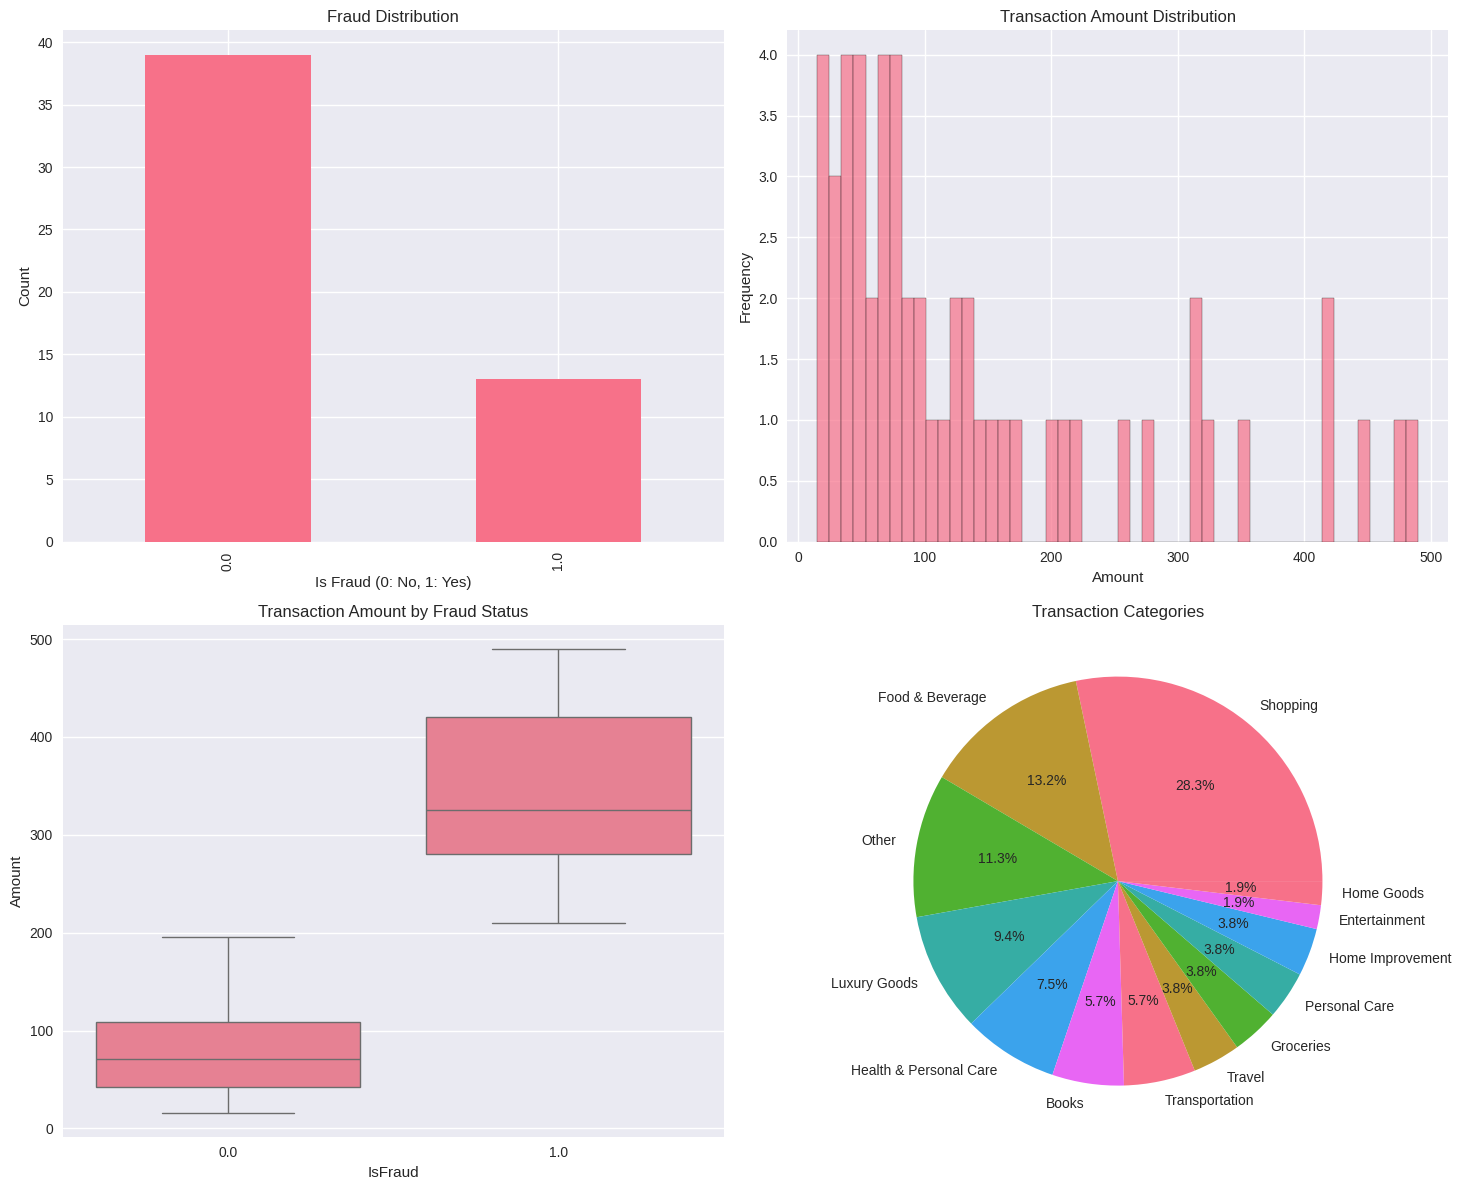

<Figure size 1200x600 with 0 Axes>

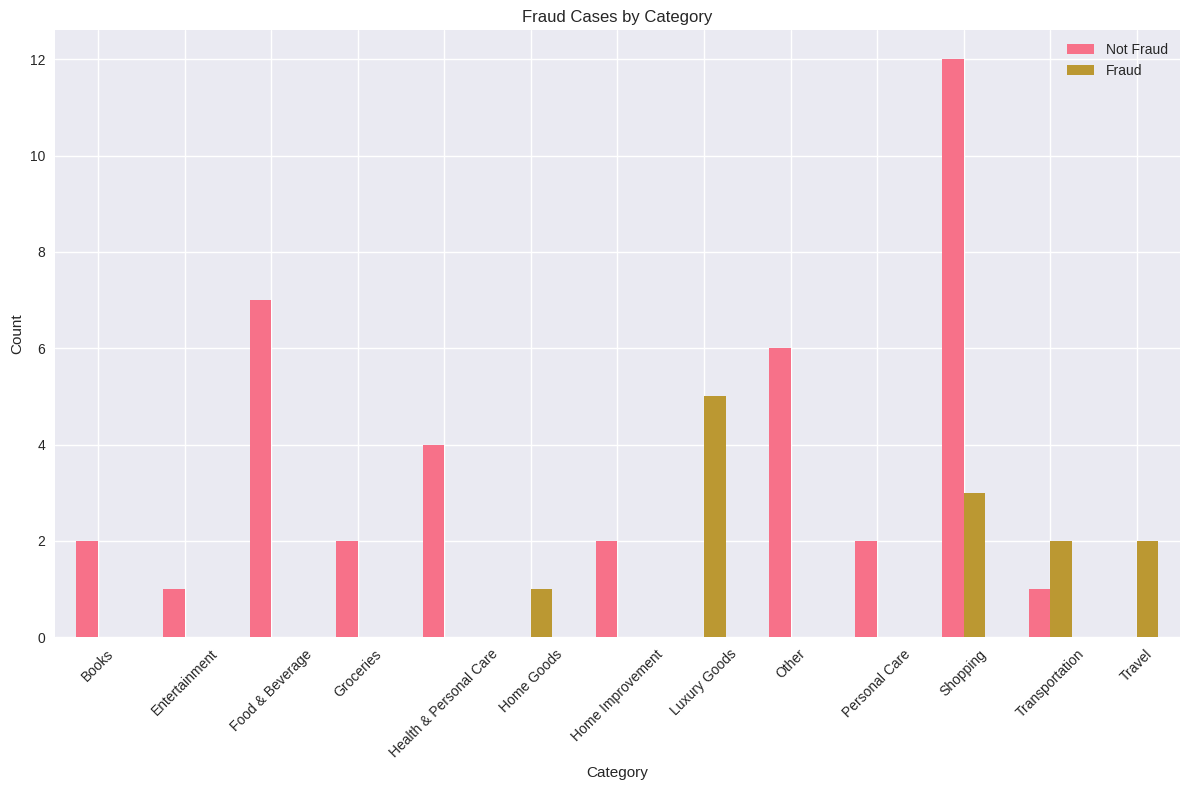

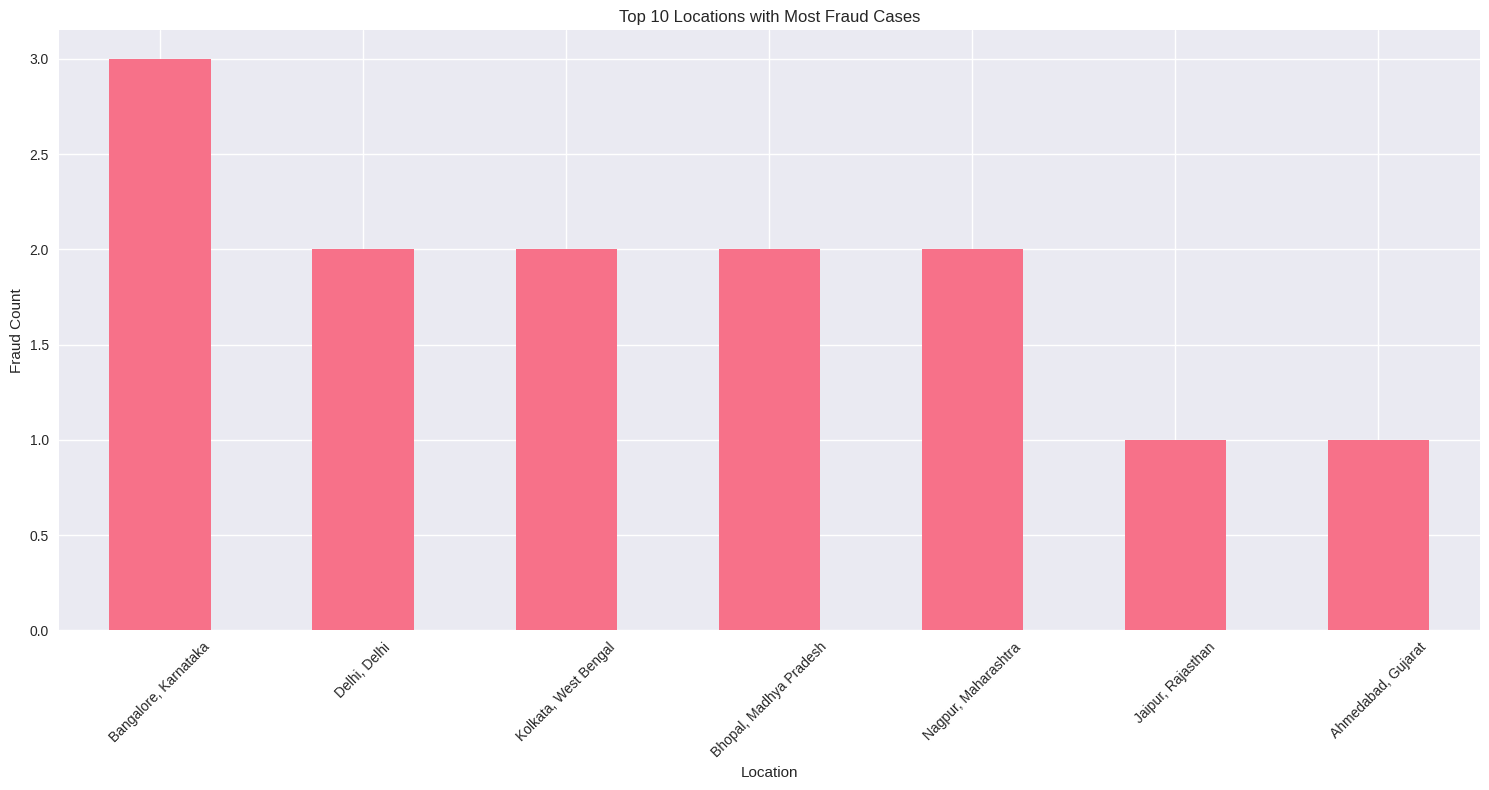


4. Preprocessing data...
Feature matrix shape: (53, 74)
Number of features: 74

5. Splitting data...


ValueError: Input y contains NaN.

In [4]:
DATA_FILE_PATH = 'dataset.csv.csv'

# Check if the file exists after uploading or if it's already in the environment
try:
    with open(DATA_FILE_PATH, 'r') as f:
        print(f"Found dataset file: {DATA_FILE_PATH}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATA_FILE_PATH}.")
    print("Please upload the 'dataset.csv.csv' file using the file explorer in the left sidebar")
    print("or by running: `from google.colab import files; uploaded = files.colab.files.upload()`")
    # Exit or handle the error gracefully if the file isn't found
    # For this example, we'll just print the message and assume the user will upload.
    # The pipeline will handle the FileNotFoundError as implemented in load_data().


# Initialize and run the pipeline using the class definition provided in the preceding code
# This assumes the FraudDetectionPipeline class is defined in the cell above or already exists in the environment
print("\nStarting the Fraud Detection Pipeline...")
DATA_FILE_PATH = 'dataset.csv.csv'

# Check if the file exists after uploading or if it's already in the environment
try:
    with open(DATA_FILE_PATH, 'r') as f:
        print(f"Found dataset file: {DATA_FILE_PATH}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATA_FILE_PATH}.")
    print("Please upload the 'dataset.csv.csv' file using the file explorer in the left sidebar")
    print("or by running: `from google.colab import files; uploaded = files.colab.files.upload()`")
    # Exit or handle the error gracefully if the file isn't found
    # For this example, we'll just print the message and assume the user will upload.
    # The pipeline will handle the FileNotFoundError as implemented in load_data().


# Initialize and run the pipeline using the class definition provided in the preceding code
# This assumes the FraudDetectionPipeline class is defined in the cell above or already exists in the environment
print("\nStarting the Fraud Detection Pipeline...")
fraud_detector = FraudDetectionPipeline(DATA_FILE_PATH)
best_model =fraud_detector.run_complete_pipeline()
print("the best model parameters after the pipeline completes")

# Optional: print the best model parameters after the pipeline completes
if best_model:
    print("\nPipeline execution finished.")
    print("\nBest trained model parameters:")
    print("best_model.get_params()")

# The detailed outputs (metrics, plots) are generated by the evaluate_models and feature_importance methods within the pipeline.
if best_model:
    print("\nPipeline execution finished.")
    print("\nBest trained model parameters:")
    print(best_model.get_params())

# The detailed outputs (metrics, plots) are generated by the evaluate_models and feature_importance methods within the pipeline.
def split_data(self, test_size=0.2, random_state=42):
    """Split the data into training and testing sets."""
    # Added check to prevent error if X or y are None
    if self.X is None or self.y is None:
        print("Data not preprocessed. Cannot split data.")
        return None, None, None, None

    # Check if y contains NaN values and remove corresponding rows from X and y
    # This is the fix for the ValueError
    if self.y.isnull().any():
        print("Warning: NaN values found in the target variable 'IsFraud'. Removing corresponding rows.")
        # Keep track of initial size
        initial_rows = len(self.y)
        # Get the index of rows with non-NaN values in y
        valid_indices = self.y.dropna().index
        # Filter X and y to keep only rows without NaN in y
        self.X = self.X.loc[valid_indices]
        self.y = self.y.loc[valid_indices]
        rows_dropped = initial_rows - len(self.y)
        if rows_dropped > 0:
             print(f"Dropped {rows_dropped} rows due to NaN in the target variable.")


    # Check if there are enough samples after removing NaNs for stratification
    # train_test_split requires at least two samples of each class for stratification
    if len(self.y.value_counts()) < 2 or (self.y.value_counts() < 2).any():
        print("Error: Not enough samples of both classes in the target variable after removing NaNs for stratification.")
        print("Cannot perform stratified split.")
        return None, None, None, None


    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
    )

    print(f"Training set shape: {self.X_train.shape}")
    print(f"Testing set shape: {self.X_test.shape}")

    # Scale the features
    self.scaler = StandardScaler()
    self.X_train_scaled = self.scaler.fit_transform(self.X_train)
    self.X_test_scaled = self.scaler.transform(self.X_test)

    return self.X_train, self.X_test, self.y_train, self.y_test


In [5]:
df.head()

,TransactionID,UserID,Amount,TransactionTime,Merchant,Category,Location,Device,IPAddress,IsFraud,Date,Hour,Day,Month,Year,DayOfWeek,State
0,1,101,55.75,2023-01-01 10:30:00,Electronics Store,Shopping,"Coimbatore, Tamil Nadu",Mobile,192.168.1.100,0.0,2023-01-01,10,1,1,2023,Sunday,Tamil Nadu
1,2,102,120.50,2023-01-01 10:45:15,Online Retailer,Shopping,"Chennai, Tamil Nadu",Web,10.0.0.5,0.0,2023-01-01,10,1,1,2023,Sunday,Tamil Nadu
2,3,103,19.99,2023-01-01 11:00:30,Coffee Shop,Food & Beverage,"Coimbatore, Tamil Nadu",Mobile,172.16.0.1,0.0,2023-01-01,11,1,1,2023,Sunday,Tamil Nadu
3,4,104,310.20,2023-01-01 11:15:45,Luxury Goods Store,Shopping,"Bangalore, Karnataka",Web,192.168.1.101,1.0,2023-01-01,11,1,1,2023,Sunday,Karnataka
4,5,105,89.90,2023-01-01 11:30:00,Bookstore,Books,"Coimbatore, Tamil Nadu",Mobile,10.0.0.6,0.0,2023-01-01,11,1,1,2023,Sunday,Tamil Nadu
